In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
RND_STATE = 51834
%matplotlib inline

## 1. Loading data

### 1.1 Data load from file

In [2]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)

In [3]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### 1.1 Data exploration

| Variable Name | Description | Type |
| :- | :- | :- |
| SeriousDlqin2yrs | Person experienced 90 days past due delinquency or worse | Y/N |
| RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
| age | Age of borrower in years | integer |
| NumberOfTime30-59DaysPastDueNotWorse | Number of times borrower has been 30-59 days past due but no worse in the last 2 years. | integer |
| DebtRatio | Monthly debt payments, alimony,living costs divided by monthy gross income | percentage |
| MonthlyIncome | Monthly income | real |
| NumberOfOpenCreditLinesAndLoans | Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) | integer |
| NumberOfTimes90DaysLate | Number of times borrower has been 90 days or more past due. | integer |
| NumberRealEstateLoansOrLines | Number of mortgage and real estate loans including home equity lines of credit | integer |
| NumberOfTime60-89DaysPastDueNotWorse | Number of times borrower has been 60-89 days past due but no worse in the last 2 years. | integer |
| NumberOfDependents | Number of dependents in family excluding themselves (spouse, children etc.) | integer |






### 1.2 Checking if classes are imbalanced

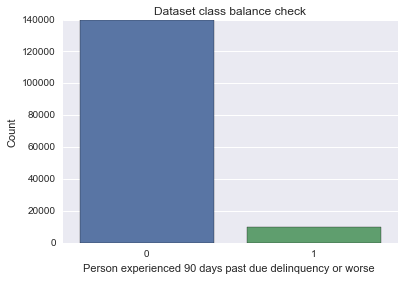

In [4]:
ax = sns.countplot(x = data.SeriousDlqin2yrs)
ax.set_title('Dataset class balance check')
ax.set_xlabel('Person experienced 90 days past due delinquency or worse ')
ax.set_ylabel('Count')
plt.show()

### 1.3 Checking for NAN values

In [5]:
def checkDataFrameNANs(df):
    print('Number of nans by property:')
    print(df.isnull().sum())

In [6]:
checkDataFrameNANs(data)

Number of nans by property:
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


## 2. Data preprocessing

### 2.1 Working with NANs

#### 2.1.1 Working with NumberOfDependents parameter 

Рассматриваемый датасет содержит пропуски в параметре NumberOfDependents. Пропусков достаточно немного, и, чтобы не удалять значения, заменим пропуски в данных медианными значениями.

In [7]:
data['NumberOfDependents'].fillna(data['NumberOfDependents'].median(), inplace = True)

#### 2.1.2 Working with MonthlyIncome parameter 

В используемом датасете очень много пустых значений параметра MonthlyIncome. 
Построим линейную регрессию для восстановления значений параметра.

In [8]:
non_null_data_monInc = data[data.MonthlyIncome.isnull() == False]
null_monInc = data[data.MonthlyIncome.isnull() == True]

monInc_y_train = non_null_data_monInc.MonthlyIncome
monInc_X_train = non_null_data_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis = 1)
null_monInc = null_monInc.drop(['MonthlyIncome', 'SeriousDlqin2yrs'], axis=1)

monIncLR = LinearRegression(fit_intercept=True, normalize=True).fit(monInc_X_train, monInc_y_train)

С помощью полученной модели предскажем значения параметра для NAN значений 

In [9]:
monInc_y_pred = monIncLR.predict(null_monInc)
monInc_y_pred[monInc_y_pred < 0] = 0
null_monInc['MonthlyIncome'] = monInc_y_pred

In [10]:
monNew = []
for index in data.index:
    if data.MonthlyIncome[index].is_integer() == True:
        monNew.append(data.MonthlyIncome[index])
    else:
        monNew.append(null_monInc.MonthlyIncome[index])
data.MonthlyIncome = monNew

#### 2.1.3 Cheking for NANs again

In [11]:
print('Number of nans by property:')
checkDataFrameNANs(data)

Number of nans by property:
Number of nans by property:
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64


### 2.2 Oversampling minor class

In [12]:
X = data.drop('SeriousDlqin2yrs', axis = 1)
y = data.SeriousDlqin2yrs

In [13]:
sm = SMOTE(random_state = RND_STATE)
X_res, y_res = sm.fit_sample(X, y)

## 3. Data prediction

### 3.1 Train test split

In [14]:
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = RND_STATE)


folds = StratifiedKFold(n_splits = 10, random_state = RND_STATE, shuffle = False)

In [16]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgboost

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from pybrain.datasets import SupervisedDataSet
from pybrain.structure import RecurrentNetwork, FullConnection
from pybrain.supervised.trainers import RPropMinusTrainer
from pybrain.structure.modules import SoftmaxLayer, SigmoidLayer, LinearLayer, TanhLayer

import seaborn as sns
from ggplot import *
from matplotlib import pylab as plt
sns.set_style("whitegrid")
%matplotlib inline
from sklearn.linear_model import LogisticRegression

/Users/aliyetefikova/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Building models

### Gradient Boosting

In [21]:
#создаем объект класса GradientBoostingClassifier() с определенным набором параметров
gb = GradientBoostingClassifier(learning_rate = 0.1, subsample = 0.7,  
                                max_features = 'sqrt', random_state = RND_STATE)
#устанавливаем диапозон параметров для скользящего контроля
gb_params = {'loss': ['deviance', 'exponential'],
             'min_samples_leaf': [2, 3, 4, 5], 
             'n_estimators': [150]}
#создаем объект класса GridSearchCV()
gb_cv = GridSearchCV(gb, param_grid = gb_params, scoring = 'roc_auc', cv = folds)
#обучаемся на обучающей выборке
gb_cv.fit(X_train, y_train)
#делаем предсказание меток класса на тестовой
gb_cv_predict = gb_cv.predict(X_test)
#делаем предсказание вероятности класса на тестовой
gb_cv_predict_proba = gb_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_gb = roc_auc_score(y_test, gb_cv_predict_proba)

In [22]:
print("ROC AUC score:", roc_auc_gb,
      "CV best score:", gb_cv.best_score_)

ROC AUC score: 0.864721565645 CV best score: 0.865124232628


In [23]:
fpr, tpr, thresholds = roc_curve(y_test, gb_cv_predict_proba)

In [24]:
print(str('False positive rate:') + '\n' + str(fpr) + '\n\n' +
      str('True positive rate:') + '\n' + str(tpr) + '\n\n' +
      str('Thresholds:') + '\n' + str(thresholds))

False positive rate:
[  0.00000000e+00   0.00000000e+00   2.38117916e-05 ...,   9.99666635e-01
   9.99785694e-01   1.00000000e+00]

True positive rate:
[  3.32889481e-04   9.98668442e-04   9.98668442e-04 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]

Thresholds:
[ 0.89052526  0.86450533  0.85451602 ...,  0.00210568  0.00209344
  0.0017142 ]


In [25]:
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.864721565645


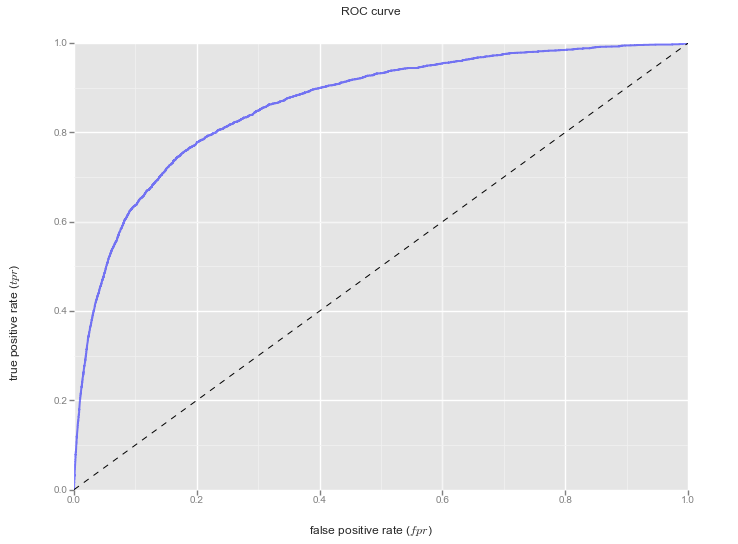

<ggplot: (-9223372036547237821)>

In [26]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='blue', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [45]:
importances_gb = gb_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
gb_zip = zip(X.columns, importances_gb) 
for a, b, in sorted(gb_zip, key = lambda zp_gb: zp_gb[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

RevolvingUtilizationOfUnsecuredLines: 0.17008352683763284
DebtRatio: 0.14017378482165208
MonthlyIncome: 0.12393192200350313
age: 0.11965897401570916
NumberOfTimes90DaysLate: 0.10042488886239198


### Random Forest

In [48]:
#количество n_splits было увеличено, чтобы избежать переобучения
folds = StratifiedKFold(n_splits = 25, random_state = RND_STATE) 
#набор параметров
params = {'criterion': ['gini', 'entropy'], 
         'max_features': [1, 5, 10, 'log2', 'auto'],
         'max_depth': [2, 4, 8, 16, 32], 
         'class_weight': ['balanced']}
#создание объекта класса GridSearchCV()
rf_cv = GridSearchCV(RandomForestClassifier(), params, 
                     scoring='roc_auc', n_jobs = -1, cv = folds)
#обучение модели
rf_cv.fit(X_train, y_train)
#предсказание меток класса
rf_cv_prediction = rf_cv.predict(X_test)
#предсказание вероятности принадлежности к одному из классов
rf_cv_prediction_proba = rf_cv.predict_proba(X_test)[:, 1]
#вычисляем значение метрики 
roc_auc_rf = roc_auc_score(y_test, rf_cv_prediction_proba)

In [49]:
print("ROC AUC score:", roc_auc_rf,
      "CV best score:", rf_cv.best_score_)

ROC AUC score: 0.857647418453 CV best score: 0.857759813963


In [51]:
fpr, tpr, thresholds = roc_curve(y_test, rf_cv_prediction_proba)

In [52]:
print(str('False positive rate:') + '\n' + str(fpr) + '\n\n' +
      str('True positive rate:') + '\n' + str(tpr) + '\n\n' +
      str('Thresholds:') + '\n' + str(thresholds))

False positive rate:
[  0.00000000e+00   2.38117916e-05   2.38117916e-05 ...,   9.99714259e-01
   9.99976188e-01   1.00000000e+00]

True positive rate:
[  3.32889481e-04   3.32889481e-04   3.99467377e-03 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]

Thresholds:
[ 0.97735825  0.97561728  0.97090525 ...,  0.03699586  0.03600157
  0.03126107]


In [53]:
print("ROC AUC score:", auc(fpr, tpr))

ROC AUC score: 0.857647418453


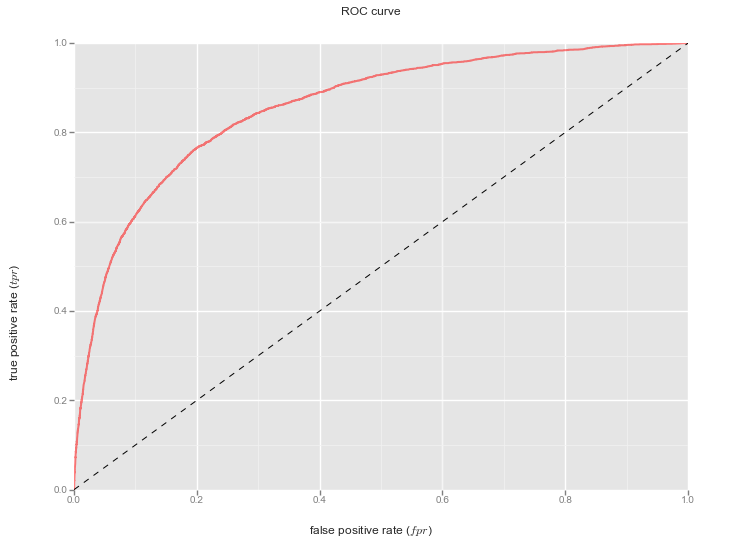

<ggplot: (-9223372036547293289)>

In [55]:
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y ='tpr')) +\
    geom_line(color='red', size = 2, alpha = 0.5) +\
    geom_abline(linetype = 'dashed') +\
    xlab("false positive rate ($fpr$)") + ylab("true positive rate ($tpr$)") + ggtitle("ROC curve")

In [58]:
importances_rf = rf_cv.best_estimator_.feature_importances_ #получение весов признаков
print(str("Топ - 5 важнейших признаков:") + '\n')
rf_zip = zip(X.columns, importances_rf) 
for a, b, in sorted(rf_zip, key = lambda zp_rf: zp_rf[1], reverse = True)[:5]:
    print("{0}: {1}".format(a, b))

Топ - 5 важнейших признаков:

RevolvingUtilizationOfUnsecuredLines: 0.30738314879636774
NumberOfTimes90DaysLate: 0.23020014320262838
NumberOfTime30-59DaysPastDueNotWorse: 0.21871021457338333
NumberOfTime60-89DaysPastDueNotWorse: 0.09517579334236788
age: 0.05531067370486918
